In [83]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [84]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


**Exercise 1**

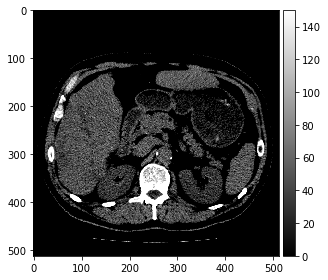

In [85]:
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

**Exercise 2**

In [86]:
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

In [103]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
print(mu_spleen, std_spleen)



49.48026905829597 14.9970794143059


In [88]:
bone_roi = io.imread(in_dir + 'BoneROI.png')
# convert to boolean image
bone_mask = bone_roi > 0
bone_values = img[bone_mask]

mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)


In [89]:
fat_roi = io.imread(in_dir + 'FatROI.png')
# convert to boolean image
fat_mask = fat_roi > 0
fat_values = img[fat_mask]

mu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)

pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)


In [90]:
kidneys_roi = io.imread(in_dir + 'KidneyROI.png')
# convert to boolean image
kidneys_mask = kidneys_roi > 0
kidneys_values = img[kidneys_mask]

mu_kidneys = np.mean(kidneys_values)
std_kidneys = np.std(kidneys_values)

pdf_kidneys = norm.pdf(hu_range, mu_kidneys, std_kidneys)

In [91]:
liver_roi = io.imread(in_dir + 'LiverROI.png')
# convert to boolean image
liver_mask = liver_roi > 0
liver_values = img[liver_mask]

mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)


In [92]:
background_roi = io.imread(in_dir + 'BackgroundROI.png')
# convert to boolean image
background_mask = background_roi > 0
background_values = img[background_mask]

mu_background = np.mean(background_values)
std_background = np.std(background_values)

pdf_background = norm.pdf(hu_range, mu_background, std_background)

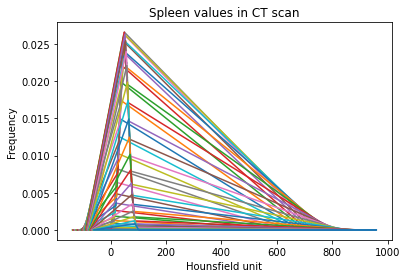

In [93]:
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

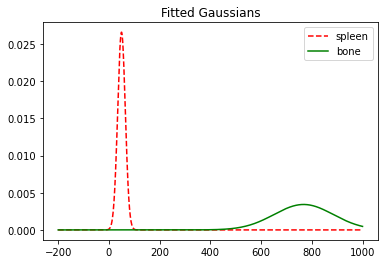

In [94]:
# Hounsfield unit limits of the plot
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Plot all together

C:\Users\joset\AppData\Local\Temp\ipykernel_9076\2502272346.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([spleen_values, kidneys_values, fat_values, bone_values, liver_values])


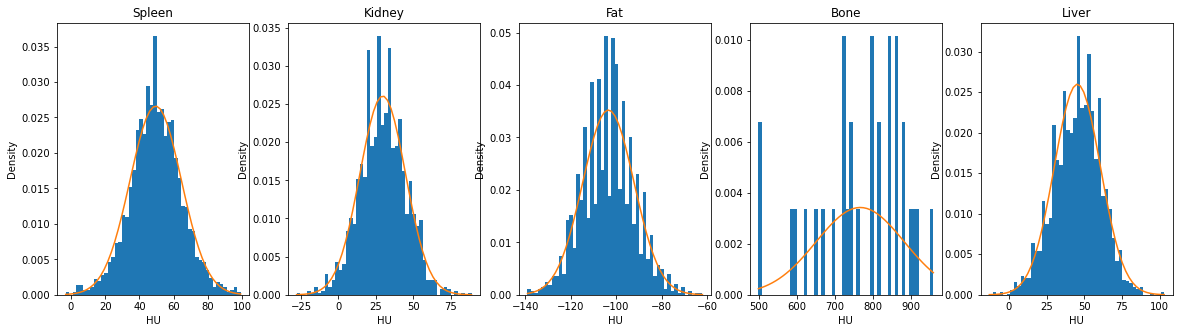

In [95]:
# gather in array for easy plotting 
means = np.array([mu_spleen, mu_kidneys, mu_fat, mu_bone, mu_liver])
stds = np.array([std_spleen, std_kidneys, std_fat, std_bone, std_liver])
titles = np.array(["Spleen", "Kidney", "Fat", "Bone", "Liver"])
values = np.array([spleen_values, kidneys_values, fat_values, bone_values, liver_values])
ns, bins, patches = [], [], []
fig, ax = plt.subplots(1, 5, figsize = (20, 5))
for i in range(5): 
    n, bin, patch = ax[i].hist(values[i].ravel(), bins = 50, density=True)
    ns.append(n), bins.append(bin), patches.append(patch)
    ax[i].plot(bin, norm.pdf(bin, means[i], stds[i]))
    ax[i].set_xlabel("HU")
    ax[i].set_ylabel("Density")
    ax[i].set_title(titles[i])
plt.show()


Intervals:
    Spleen: [0, 100]
    Kidney: [-25, 75]
    Fat: [-140, -60]
    Bone: [500, 900]
    Liver: [0, 100]
    Background: ¿?

The easiest to classify = fat and bone 
Hard to separate = spleen and liver
kidney more or less difficult




**Minimum distance pixel classification**

-200 -30.190784679297884 404.9731539483675


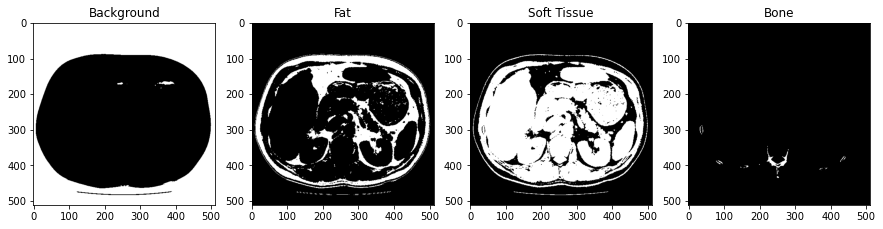

In [96]:
t_background = -200
soft_tissue_values = np.append(kidneys_values, spleen_values)
soft_tissue_values = np.append(soft_tissue_values, liver_values)
(mu_soft, std_soft) = norm.fit(soft_tissue_values)
#get intersection of classes

t_fat_soft = (mu_soft + mu_fat)/2
t_soft_bone = (mu_soft + mu_bone)/2

print(t_background, t_fat_soft, t_soft_bone)

#Divide image in classes

background_img = (img < t_background)
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = (img > t_soft_bone)
# soft_img = (img > )


fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

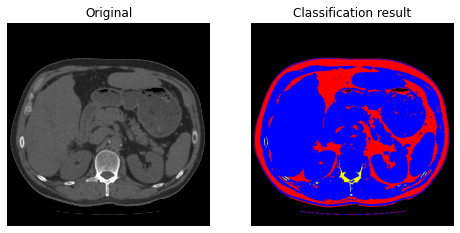

In [97]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

**Parametric pixel classification**

**Exercise 9**

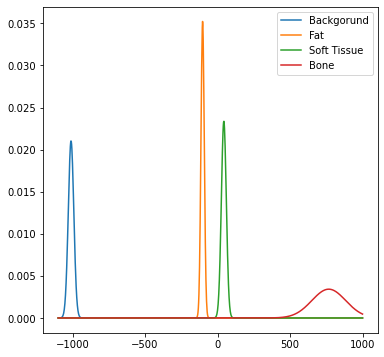

In [98]:
# Exercise 9 
means = np.array([mu_background, mu_fat, mu_soft, mu_bone])
stds = np.array([std_background, std_fat, std_soft, std_bone])
titles = np.array(["Backgorund", "Fat", "Soft Tissue", "Bone"])
x = np.linspace(-1100, 1000, 1000)
plt.figure(figsize = (6, 6))
for i in range(4): 
    plt.plot(x, norm.pdf(x, means[i], stds[i]), label = titles[i])
plt.legend()
plt.show()

In [99]:
for test_value in range(-50, -30):
    if norm.pdf(test_value, mu_fat, std_fat) > norm.pdf(test_value, mu_soft, std_soft):
        print(f"For value {test_value} the class is fat")
    else:
        print(f"For value {test_value} the class is soft tissue")
        


For value -50 the class is fat
For value -49 the class is fat
For value -48 the class is fat
For value -47 the class is fat
For value -46 the class is fat
For value -45 the class is fat
For value -44 the class is soft tissue
For value -43 the class is soft tissue
For value -42 the class is soft tissue
For value -41 the class is soft tissue
For value -40 the class is soft tissue
For value -39 the class is soft tissue
For value -38 the class is soft tissue
For value -37 the class is soft tissue
For value -36 the class is soft tissue
For value -35 the class is soft tissue
For value -34 the class is soft tissue
For value -33 the class is soft tissue
For value -32 the class is soft tissue
For value -31 the class is soft tissue


In [100]:
for test_value in range(120, 160):
    if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
        print(f"For value {test_value} the class is soft")
    else:
        print(f"For value {test_value} the class is bone")
        


For value 120 the class is soft
For value 121 the class is soft
For value 122 the class is soft
For value 123 the class is soft
For value 124 the class is soft
For value 125 the class is soft
For value 126 the class is soft
For value 127 the class is soft
For value 128 the class is soft
For value 129 the class is soft
For value 130 the class is soft
For value 131 the class is soft
For value 132 the class is soft
For value 133 the class is soft
For value 134 the class is soft
For value 135 the class is soft
For value 136 the class is soft
For value 137 the class is soft
For value 138 the class is soft
For value 139 the class is soft
For value 140 the class is soft
For value 141 the class is bone
For value 142 the class is bone
For value 143 the class is bone
For value 144 the class is bone
For value 145 the class is bone
For value 146 the class is bone
For value 147 the class is bone
For value 148 the class is bone
For value 149 the class is bone
For value 150 the class is bone
For valu

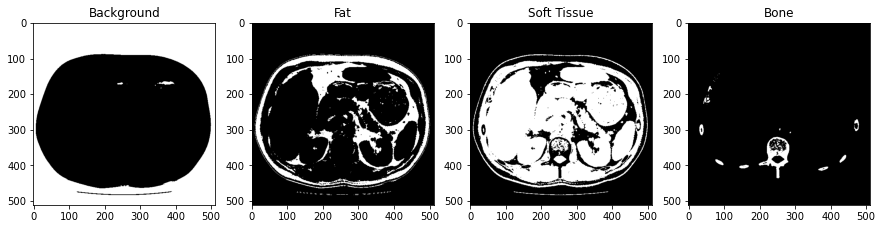

In [101]:
t_background = -200
t_fat_soft = -45 
t_soft_bone = 141

# compute bimary images 
background_img = img <= t_background 
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone 

fig, ax = plt.subplots(1, 4, figsize = (15, 5))
ax[0].imshow(background_img, cmap = "gray")
ax[0].set_title("Background")
ax[1].imshow(fat_img, cmap = "gray")
ax[1].set_title("Fat")
ax[2].imshow(soft_img, cmap = "gray")
ax[2].set_title("Soft Tissue")
ax[3].imshow(bone_img, cmap = "gray")
ax[3].set_title("Bone")
plt.show()

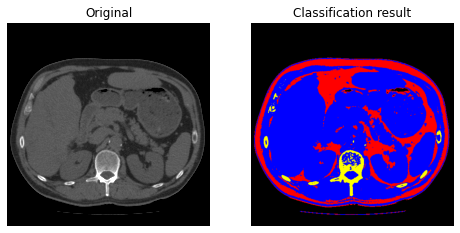

In [102]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

**Object segmentation - The spleen finder**

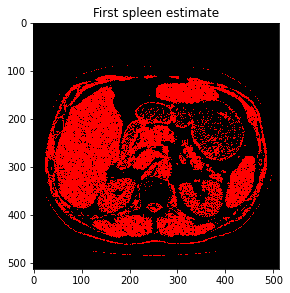

In [104]:
t_1 = 20
t_2 = 80
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

c:\Users\joset\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


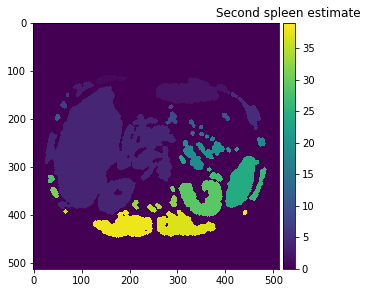

In [108]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(4)
opened = binary_opening(closed, footprint)

label_img = measure.label(opened)

io.imshow(label_img)
plt.title("Second spleen estimate")
io.show()

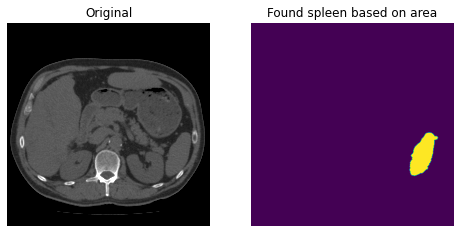

In [112]:
min_area = 2000
max_area = 10000 
min_ecc = 0.90
max_perimeter = 350 

region_props = measure.regionprops(label_img)
# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or \
 			region.perimeter > max_perimeter:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

In [129]:

def spleen_finder(img):
    
    t_1 = 20
    t_2 = 80
    spleen_estimate = (img > t_1) & (img < t_2)
    spleen_label_colour = color.label2rgb(spleen_estimate)
    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)

    footprint = disk(4)
    opened = binary_opening(closed, footprint)

    label_img = measure.label(opened)
    
    min_area = 2000
    max_area = 10000 
    min_ecc = 0.90
    max_perimeter = 350 

    region_props = measure.regionprops(label_img)
    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or \
                region.perimeter > max_perimeter:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    # Create binary image from the filtered label image
    i_area = label_img_filter > 0
    show_comparison(img, i_area, 'Found spleen based on area')
    return i_area
    

(512, 512)
int16


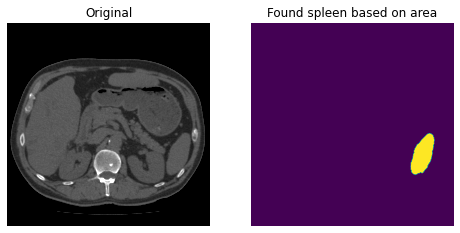

In [121]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Validation1.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)
spleen_finder(img)

(512, 512)
int16


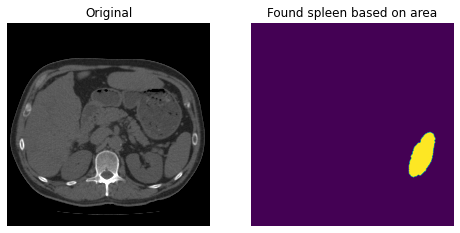

In [122]:
ct = dicom.read_file(in_dir + 'Validation2.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)
spleen_finder(img)

**DICE Score**

In [125]:
ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.9565613955079239


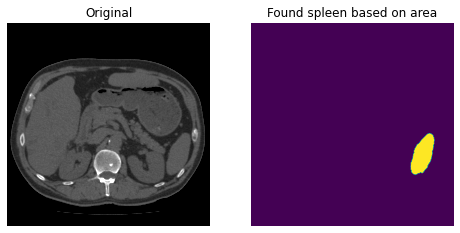

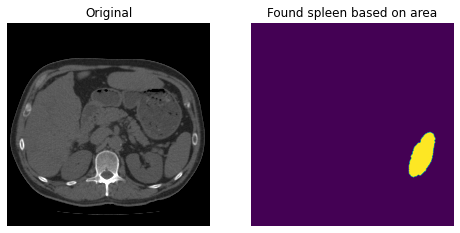

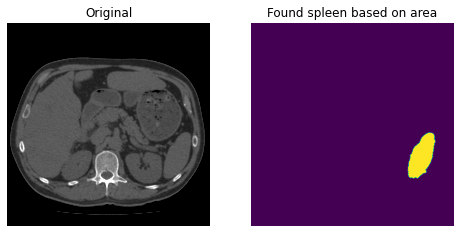

Score 1 = 0.9558359621451105, Score 2 = 0.9471671530643051, Score 3 = 0.9715459078908771


In [130]:
# Exercise 17
# Get predictions 
val1, val2, val3 = io.imread("data/Validation1.dcm"), io.imread("data/Validation2.dcm"), io.imread("data/Validation3.dcm")

pred1 = spleen_finder(val1)
pred2 = spleen_finder(val2)
pred3 = spleen_finder(val3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Validation1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Validation2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Validation3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

**Testing on an independent test set**

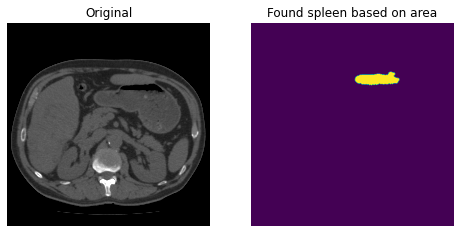

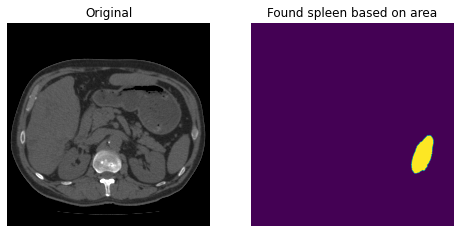

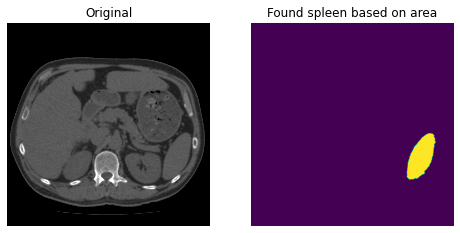

Score 1 = 0.0, Score 2 = 0.7986086956521739, Score 3 = 0.9666443658606518


In [132]:
val1, val2, val3 = io.imread("data/Test1.dcm"), io.imread("data/Test2.dcm"), io.imread("data/Test3.dcm")

pred1 = spleen_finder(val1)
pred2 = spleen_finder(val2)
pred3 = spleen_finder(val3)

# get ground thruths 
gt_1 = (io.imread(in_dir + 'Validation1_spleen.png') > 0)
gt_2 = (io.imread(in_dir + 'Validation2_spleen.png') > 0)
gt_3 = (io.imread(in_dir + 'Validation3_spleen.png') > 0)

# get dice scores 
score1 = 1 - distance.dice(pred1.ravel(), gt_1.ravel())
score2 = 1 - distance.dice(pred2.ravel(), gt_3.ravel())
score3 = 1 - distance.dice(pred3.ravel(), gt_3.ravel())

print(f"Score 1 = {score1}, Score 2 = {score2}, Score 3 = {score3}")

